In [679]:
#import the needed packages and other cool stuff you need to rune verything
from plantcv import plantcv as pcv
import matplotlib
import cv2
import numpy as np
import argparse 
from  matplotlib import pyplot as plt
import os
from skimage import exposure, img_as_float

#set debug to plot so that you can see what is happening to the image
%matplotlib notebook
pcv.params.debug = "plot"
pcv.__version__


# AB BECAUSE USING 'A' AND 'B' CHANNELS 

'3.14.3+942.ge1c4fda1.dirty'

In [680]:
#import a sample image and define it to use later in the notebook
class options:
    def __init__(self):
        # Input image path/filename
        self.image = "/Users/jstanton/desktop/1/20.png"
        # Debug mode = None, "plot", or "print"
        self.debug = "plot"
        # Store output images (True/False)
        self.writeimg = False
        # Results path/filename
        self.result = "data_output"
        # Image output directory path
        self.outdir = "img_output"

args = options()
pcv.params.debug_outdir = args.outdir
pcv.params.debug = args.debug

# Increase text size in plots
pcv.params.text_size = 20
pcv.params.text_thickness = 10

In [681]:
def affine_color_correction(img, source_matrix, target_matrix):
    h,w,c = img.shape
    n = source_matrix.shape[0]
    S = np.concatenate((source_matrix[:,1:].copy(),np.ones((n,1))),axis=1)
    T = target_matrix[:,1:].copy()
    
    tr = T[:,0]
    tg = T[:,1]
    tb = T[:,2]
    
    ar = np.matmul(np.linalg.pinv(S), tr)
    ag = np.matmul(np.linalg.pinv(S), tg)
    ab = np.matmul(np.linalg.pinv(S), tb)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pix = np.concatenate((img_rgb.reshape(h*w,c).astype(np.float64)/255, np.ones((h*w,1))), axis=1)
    
    img_r_cc = (255*np.clip(np.matmul(img_pix,ar),0,1)).astype(np.uint8)
    img_g_cc = (255*np.clip(np.matmul(img_pix,ag),0,1)).astype(np.uint8)
    img_b_cc = (255*np.clip(np.matmul(img_pix,ab),0,1)).astype(np.uint8)
    
    img_cc = np.stack((img_b_cc,img_g_cc,img_r_cc), axis=1).reshape(h,w,c)
    
    return img_cc

<IPython.core.display.Javascript object>


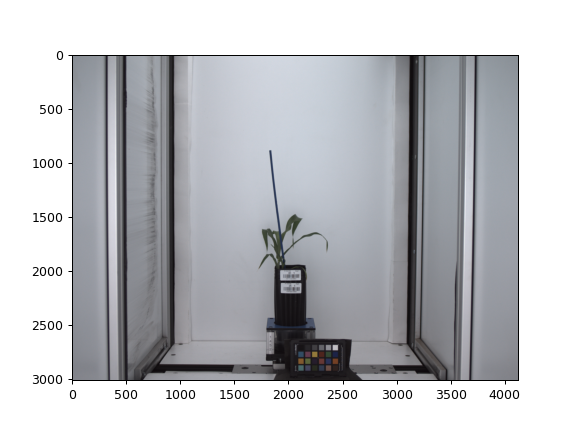

In [682]:
#define your images and your image to color correct to
img, path, filename = pcv.readimage(filename=args.image)

In [683]:
# #define the function to color correct lemnatec bellwether images, specific to July 2022 with the older camera
# def log_correct_v(img, max_val=255):
    
#     img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

#     img_hsv_f = img_hsv.astype(np.float64)
#     log_imgv = np.log(img_hsv_f[:,:,2]+1)

#     log_imgv = log_imgv - np.min(log_imgv)
#     log_imgv = max_val*(log_imgv/np.max(log_imgv))

#     img_hsv_f_corrected = img_hsv_f.copy()
#     img_hsv_f_corrected[:,:,2] = log_imgv

#     img_hsv_c = np.clip(img_hsv_f_corrected,0,max_val).astype(np.uint8)

#     img_corrected = cv2.cvtColor(img_hsv_c, cv2.COLOR_HSV2BGR)

#     pcv.plot_image(img_corrected)
    
#     return img_corrected


In [684]:
#perform log correction using your defined function
plant_logv = img

In [685]:
#define the color card dataframe for the image you are playing with
dataframe2, start2, space2 = pcv.transform.find_color_card(rgb_img=plant_logv, background='light')

<IPython.core.display.Javascript object>


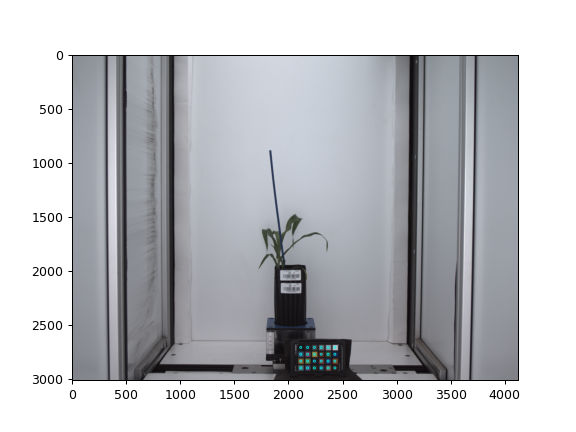

<IPython.core.display.Javascript object>


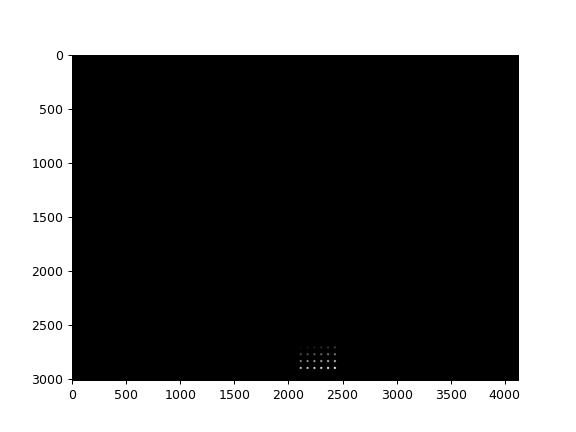

In [686]:
#make a color card mask for your image that you are playing with here

source_mask = pcv.transform.create_color_card_mask(plant_logv, radius=10, start_coord=start2, 
                                                   spacing=space2, nrows=4, ncols=6)

In [687]:
#make color card matrix for image you are playing with
headers, source_matrix = pcv.transform.get_color_matrix(rgb_img=plant_logv, mask=source_mask)

<IPython.core.display.Javascript object>


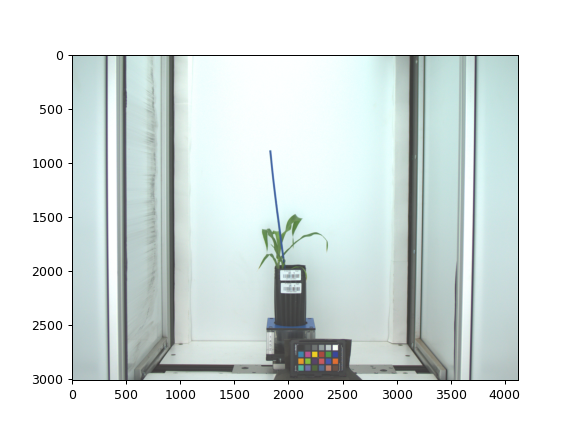

In [688]:
#load the color card values that they should be
target_matrix = pcv.transform.load_matrix(filename='/Users/jstanton/Coding/Danforth_Projects/PlantCV/PlantCV_Workflows/x-rite_color_matrix_k2.npz')

color_corrected_img = affine_color_correction(plant_logv, source_matrix, target_matrix)

pcv.plot_image(color_corrected_img)

<IPython.core.display.Javascript object>


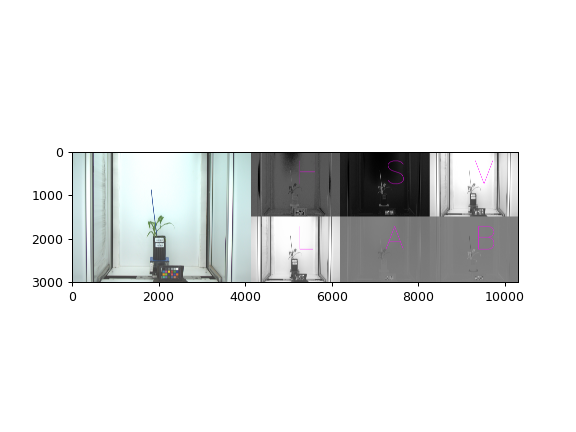

In [689]:
# Update params related to plotting so we can see better 
pcv.params.text_size=50
pcv.params.text_thickness=15


#visualize the colorspace so you can tell which channels will be the most interesting
colorspace_img = pcv.visualize.colorspaces(rgb_img=color_corrected_img)

In [690]:
pcv.print_image(color_corrected_img, filename = "./color_corrected_img.png")

In [691]:
#color_scatter = pcv.visualize.pixel_scatter_plot(paths_to_imgs = ["./color_corrected_img.png"] , x_channel = "a", y_channel ="b" )

In [692]:
#box on right 
#box_right_img, binary, contours, hierarchy = pcv.rectangle_mask(img=color_corrected_img, p1=(2020,2696), p2=(3300,2), color = "white")

In [693]:
#creating box on left 
#box_left_and_right_img, binary, contours, hierarchy = pcv.rectangle_mask(img=box_right_img, p1=(0,2688), p2=(570,2), color = "white")

<IPython.core.display.Javascript object>


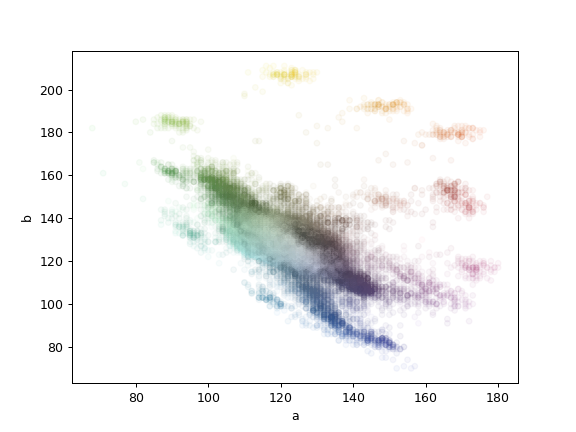

In [694]:
color_scatter = pcv.visualize.pixel_scatter_plot(paths_to_imgs = ["./color_corrected_img.png"] , x_channel = "a", y_channel ="b" )

<IPython.core.display.Javascript object>


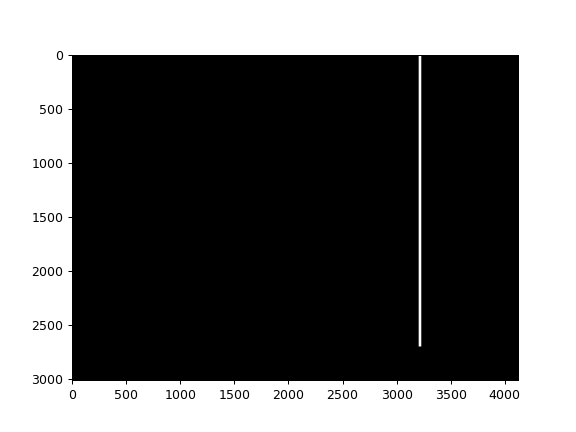

<IPython.core.display.Javascript object>


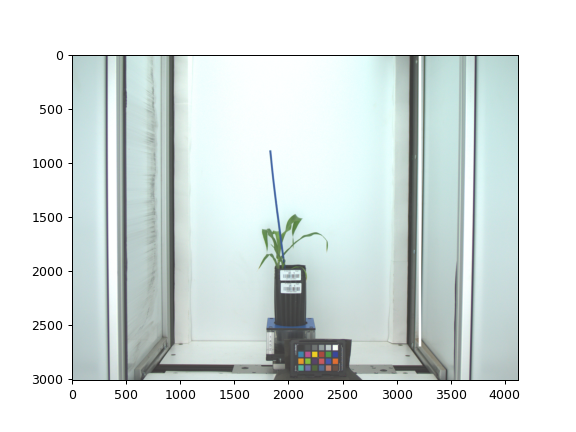

In [695]:
box_right_img, binary, contours, hierarchy = pcv.rectangle_mask(img=color_corrected_img, p1=(3200,2696), p2=(3223,2), color = "white")

<IPython.core.display.Javascript object>


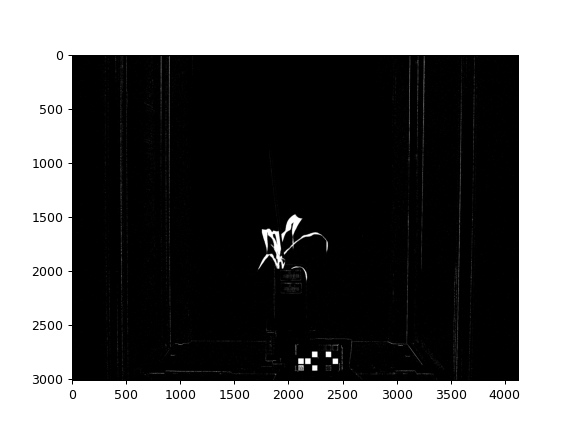

In [696]:
#B channel was originally 100,80 130,160
# A (105,130)
# (20,130),(125,150) ns004?
thresh1 = pcv.threshold.dual_channels(rgb_img = box_right_img, x_channel = "a", y_channel = "b", points = [(90,130),(131,146)], above=True, max_value=255)

In [697]:
#blurred_img = pcv.median_blur(thresh1,3)

<IPython.core.display.Javascript object>


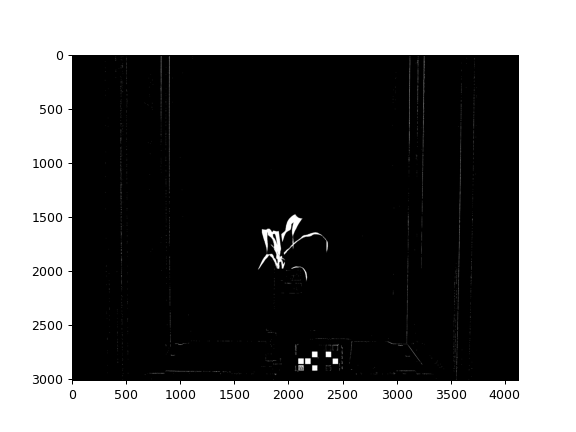

In [698]:
#get rid of noise ///////////
thresh1_fill = pcv.fill(bin_img=thresh1, size=3.5)

In [699]:
#blurred_img = pcv.median_blur(thresh1,3)

<IPython.core.display.Javascript object>


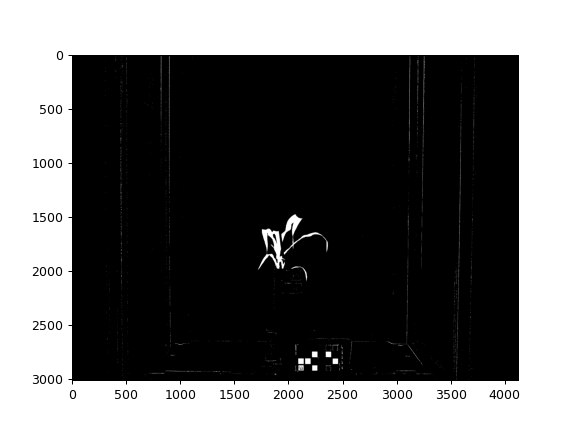

In [700]:
# Fill in small objects #does not even take a sizing parameter #obviouspepper
thresh1_filled_holes = pcv.closing(gray_img=thresh1_fill)

<IPython.core.display.Javascript object>


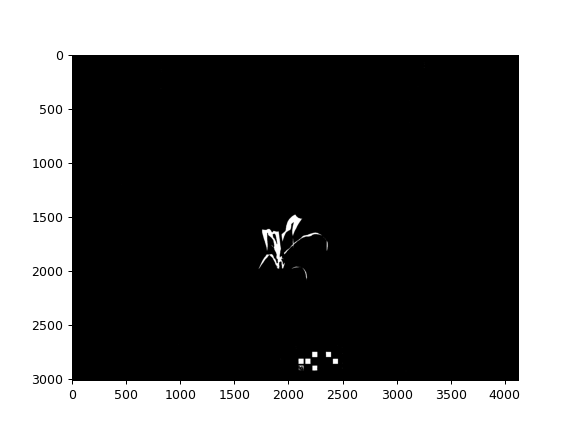

In [701]:
# maybe try this function here?
# use erode function here or below code below 
er_img = pcv.erode(gray_img=thresh1_filled_holes, ksize=4, i=1)

In [702]:
#box on right 
#box_right_img, binary, contours, hierarchy = pcv.rectangle_mask(img=er_img, p1=(3200,2696), p2=(3223,2), color = "white")

<IPython.core.display.Javascript object>


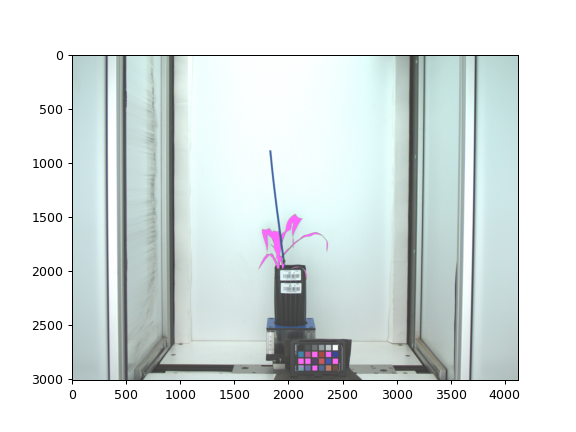

In [703]:
id_objects_ab, obj_hierarchy_ab = pcv.find_objects(img=color_corrected_img, mask=er_img)

<IPython.core.display.Javascript object>


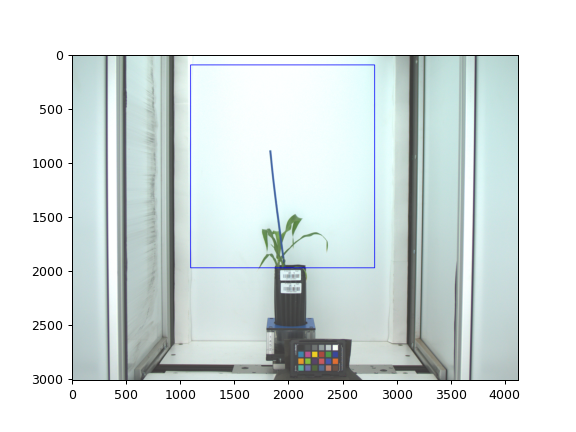

In [704]:
# y = 432 h = 900?
# 82 125
roi_ab, roi_hierarchy_ab= pcv.roi.rectangle(img=color_corrected_img, x=1094, y=100, h=1872, w=1700)

<IPython.core.display.Javascript object>


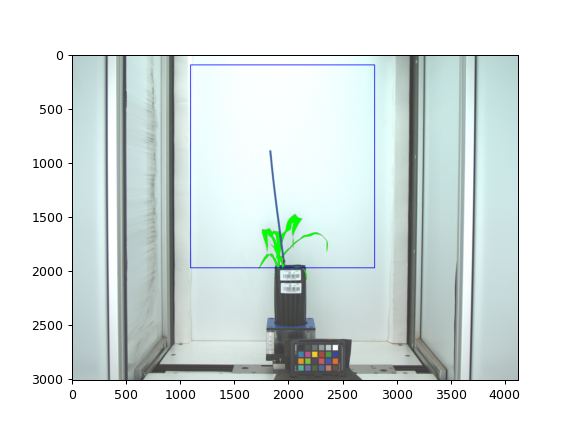

<IPython.core.display.Javascript object>


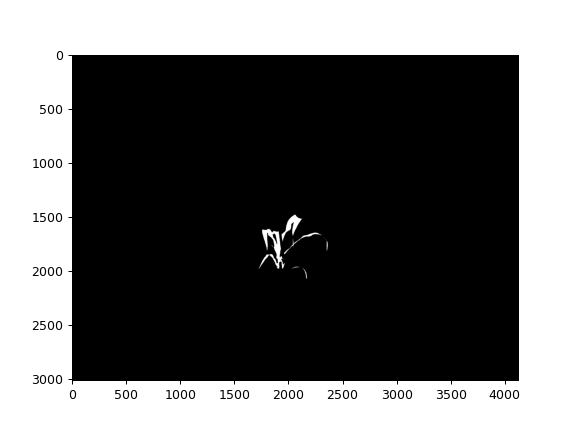

In [705]:
roi_objects_ab, hierarchy_ab, kept_mask_ab, obj_area_ab = pcv.roi_objects(img=color_corrected_img, roi_contour=roi_ab, 
                                                               roi_hierarchy=roi_hierarchy_ab, 
                                                               object_contour=id_objects_ab, 
                                                               obj_hierarchy=obj_hierarchy_ab,
                                                               roi_type='partial')

In [706]:
# pcv.params.text_size=5
# pcv.params.text_thickness = 2
# plotting_img = pcv.visualize.obj_sizes(img=color_corrected_img, mask=thresh1_filled_holes, num_objects=200)

<IPython.core.display.Javascript object>


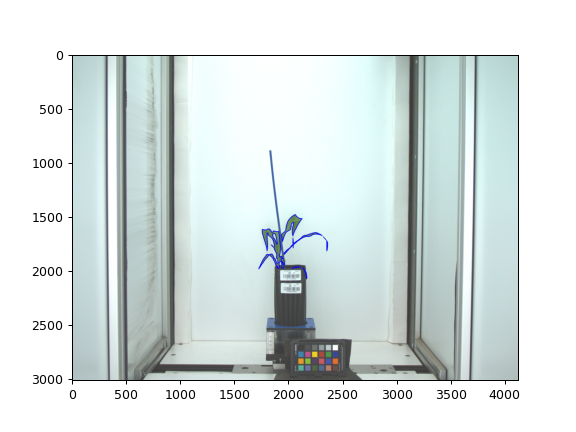

<IPython.core.display.Javascript object>


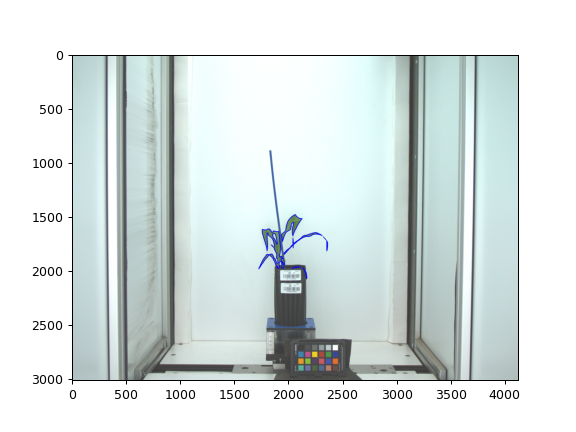

<IPython.core.display.Javascript object>


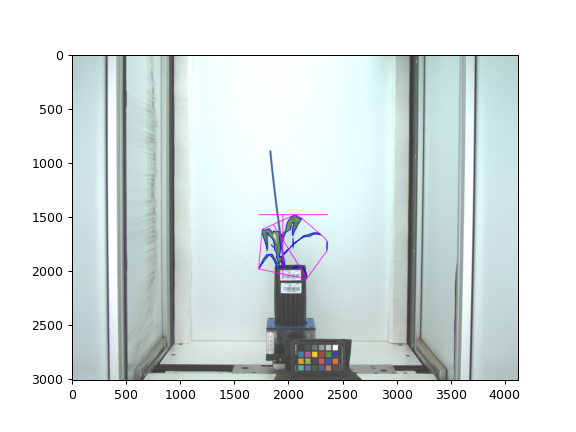

<IPython.core.display.Javascript object>


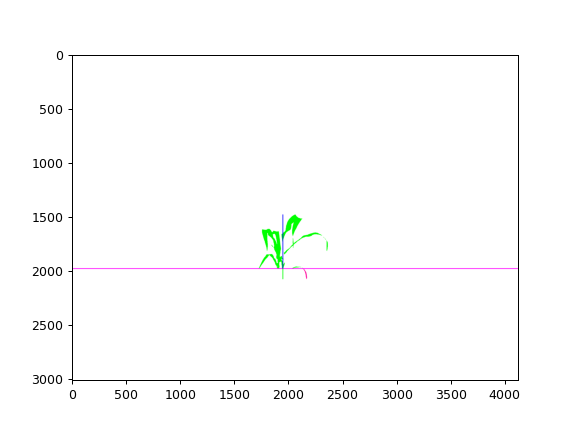

/Users/jstanton/plantcv/plantcv/plantcv/plot_image.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


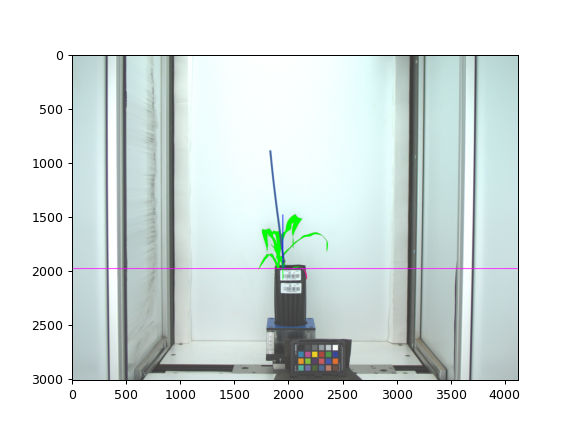

In [707]:
if obj_area_ab > 4:
    #combine kept objects
    obj_combined_ab, kept_mask_ab = pcv.object_composition(img=color_corrected_img, contours=roi_objects_ab, hierarchy=hierarchy_ab)

    # Find shape properties, data gets stored to an Outputs class automatically
    analysis_image = pcv.analyze_object(img=color_corrected_img, obj=obj_combined_ab, mask=kept_mask_ab, label="default")
    boundary_image = pcv.analyze_bound_horizontal(img=color_corrected_img, obj=obj_combined_ab, mask=kept_mask_ab, 
                                               line_position=1982, label="default")
    #pcv.print_image(analysis_image, filename = "./analysis_image.png")
    #pcv.print_image(boundary_image, filename = "./boundary_image.png")

<IPython.core.display.Javascript object>


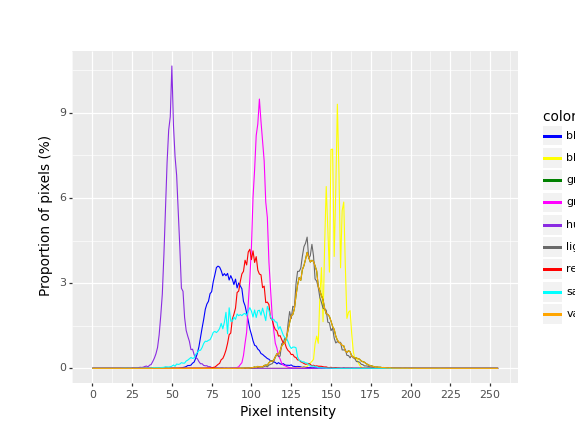

In [708]:
 # Determine color properties
color_histogram = pcv.analyze_color(rgb_img=color_corrected_img, mask=kept_mask_ab, colorspaces='all', label="default")

In [709]:
#pcv.outputs.observations["default"]["height"]["value"] 

In [710]:
#pcv.outputs.observations["default"]["area"]["value"] 

In [711]:
#pcv.outputs.observations["default"]["width"]["value"] 

In [712]:
#pcv.outputs.observations["default"]["perimeter"]["value"] 

In [713]:
#pcv.print_image(analysis_image, filename = "test.png")

In [714]:
#pcv.outputs.save_results(filename=args.result)